MLP 1 Learning Rate: 0.01


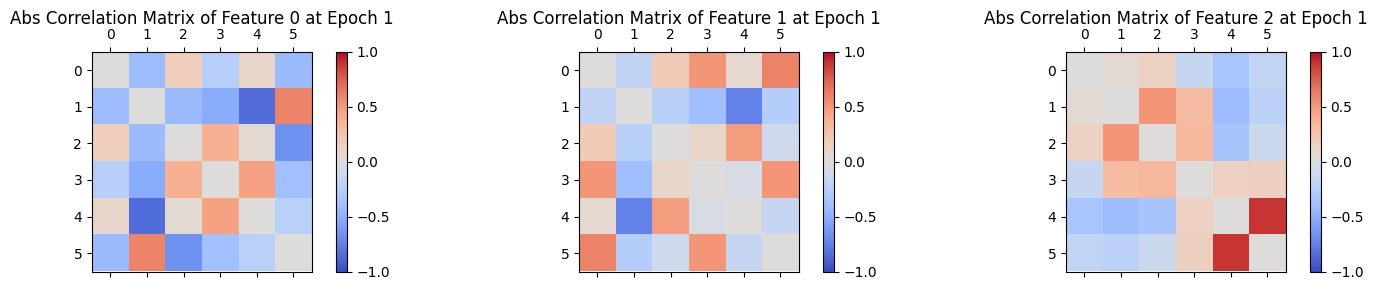

Epoch 1, MSE Loss: 15.434013366699219, Correlation Loss: 29.123830795288086


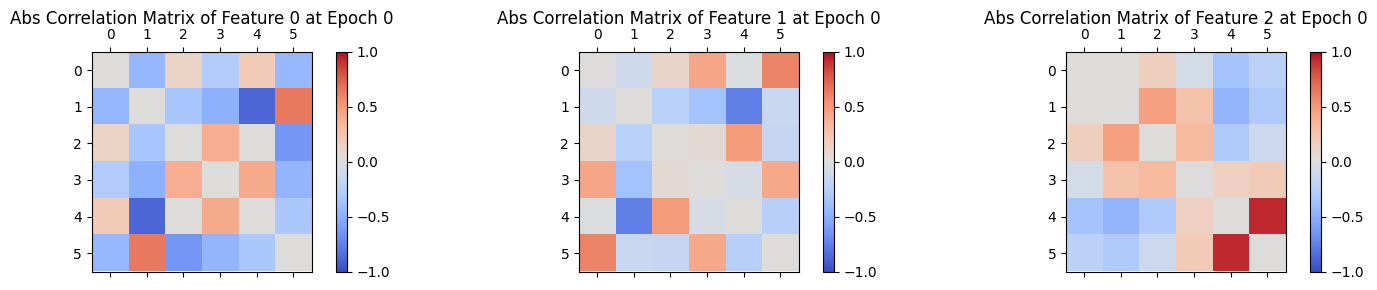

Epoch 1001, MSE Loss: 0.198044091463089, Correlation Loss: 0.4449141323566437


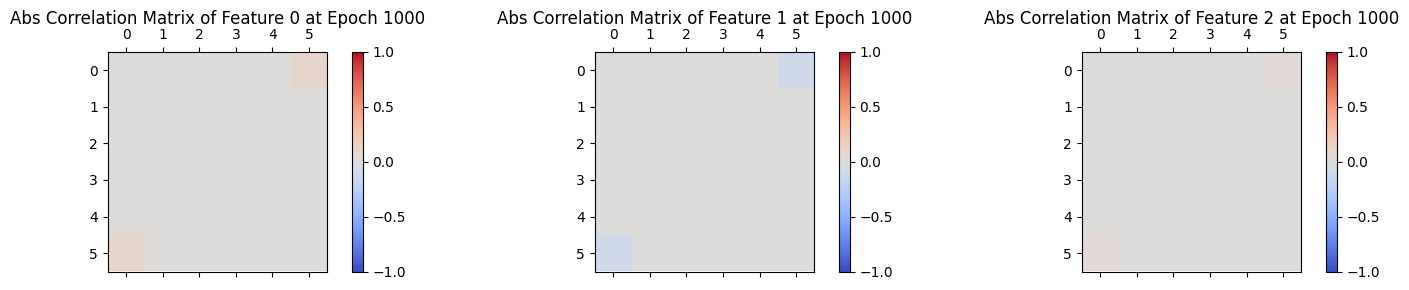

Epoch 2001, MSE Loss: 0.027314137667417526, Correlation Loss: 0.48781195282936096


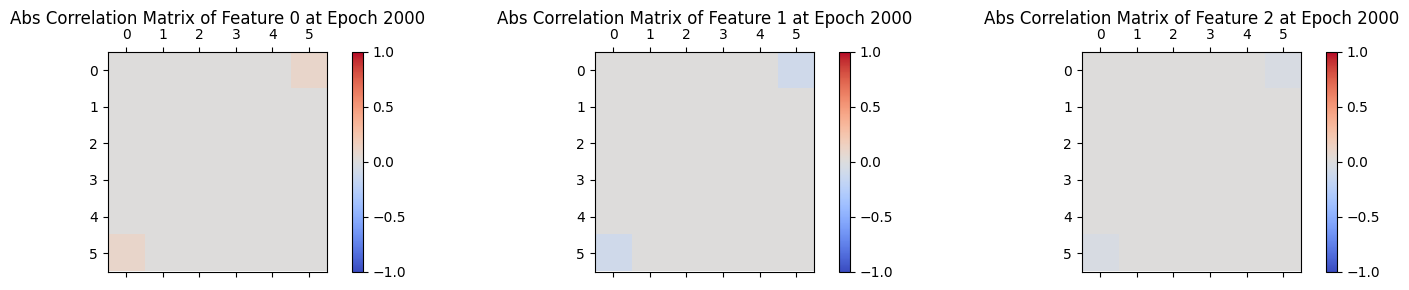

Epoch 3001, MSE Loss: 0.035516973584890366, Correlation Loss: 0.8382984399795532


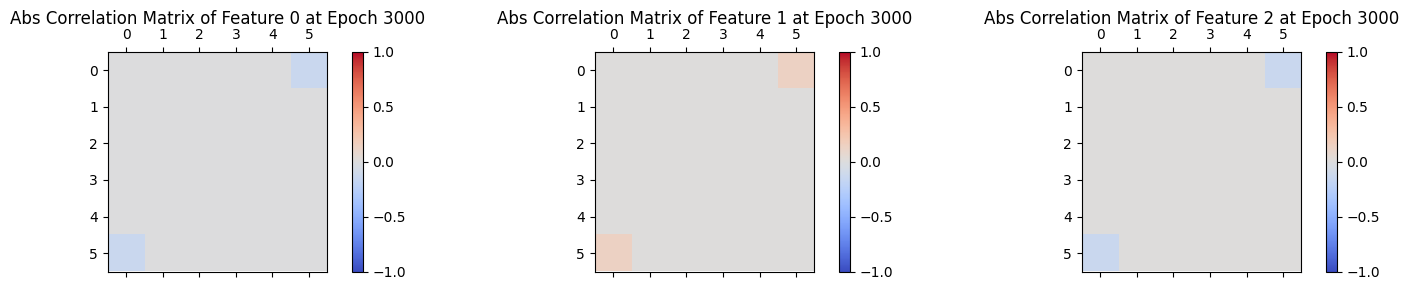

Epoch 4001, MSE Loss: 0.034668371081352234, Correlation Loss: 0.09367991983890533


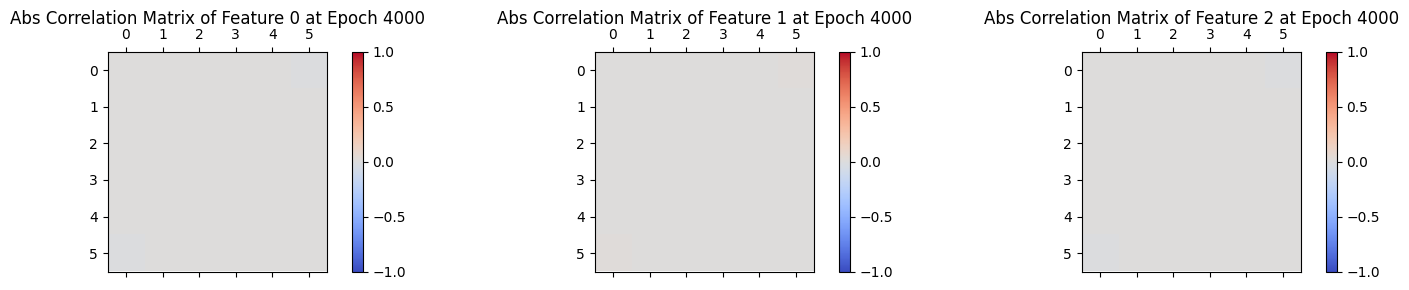

In [21]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.pyplot as plt

def plot_predictions_vs_train(predictions, train_data, title="Predictions vs Training Data", xlabel="Training Data", ylabel="Predictions"):
    # Ensure predictions and train_data are numpy arrays for compatibility with matplotlib
    if isinstance(predictions, t.Tensor):
        predictions = predictions.detach().cpu().numpy()

    if isinstance(train_data, t.Tensor):
        train_data = train_data.detach().cpu().numpy()

    plt.figure(figsize=(10, 6))

    # Scatter plot of training data
    plt.scatter(train_data, predictions, label='Data Points', alpha=0.5, color='blue')

    # Optional: plot a line of best fit
    # You can uncomment the next two lines to plot the line of best fit for the scatter plot
    # m, b = np.polyfit(train_data.flatten(), predictions.flatten(), 1)
    # plt.plot(train_data, m*train_data + b, color='red')

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.show()
    
class MLPLayer(nn.Module):
    def __init__(self, input_dim, output_dim, scale=.1, hidden_dim=3 ):
        super(MLPLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.initialize_weights(scale)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def initialize_weights(self, scale):
        # Initialize weights with scaled He initialization
        nn.init.kaiming_normal_(self.fc1.weight, a=0, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, a=0, mode='fan_in', nonlinearity='relu')

        # Scaling the weights
        self.fc1.weight.data *= scale
        self.fc2.weight.data *= scale

        # If you also want to initialize biases to some value (zero in this example)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)


def corr_matrix(data):
    epsilon = 1e-8
    mean = t.mean(data, dim=0, keepdim=True)
    demeaned_data = data - mean
    covariance = t.mm(demeaned_data.T, demeaned_data) / (data.shape[0] - 1)
    std_dev = t.sqrt(t.diag(covariance) + epsilon).unsqueeze(1)
    correlation = covariance / (std_dev @ std_dev.T)
    correlation -= t.diag(t.diag(correlation))   
    return correlation

# Function to compute correlation of a list of activations
def compute_matrices(*activations, cofunction=corr_matrix):
    #batch, heads, features 
    a = t.stack(activations, dim=1)  #stack across heads
    return [ cofunction(a[:,:,f]) for f in range(a.shape[2]) ] # loop over features

def minimize_matrix_loss(*activations):
    return sum( [ matrix.abs().sum() for i,matrix in enumerate(compute_matrices(*activations))] )  

def plot_matrices(activations, epoch, cols=3):
    matrices = compute_matrices(*activations)
    rows = (len(matrices) + cols - 1) // cols  # Compute the number of rows required
    plt.figure(figsize=(15, 3*rows))
    for i, matrix in enumerate(matrices):
        matrix_np = matrix.detach().numpy()
        plt.subplot(rows, cols, i+1)
        cax = plt.matshow(matrix_np, cmap=plt.cm.coolwarm, vmin=-1, vmax=1, fignum=False)
        plt.colorbar(cax)
        plt.title(f'Abs Correlation Matrix of Feature {i} at Epoch {epoch}', pad=20)
    plt.tight_layout()
    plt.show()

# Generate synthetic data
n_samples  = 1000
n_features = 3
n_heads    = 6

X = t.randn((n_samples, n_features))
coefficients = t.tensor([ float(i) for i in range(1, n_features+1)])
Y = t.sum(coefficients * X, dim=1, keepdim=True)  + 0.1 * t.randn((n_samples, 1))

mlps           = [ MLPLayer(n_features, n_features) if i>0 else MLPLayer(n_features, n_features,scale=1.0) for i in range(n_heads)  ]  

# learning_rates = [0.01 * (i+1) for i in range(n_heads)]
# optimizer      = optim.Adam([{'params': mlp.parameters(), 'lr': lr} for mlp, lr in zip(mlps, learning_rates)])
optimizer      = optim.Adam( [param for mlp in mlps for param in mlp.parameters()], lr=0.01,weight_decay=0.1)

# Print optimizer's state_dict to verify learning rates
for i, param_group in enumerate(optimizer.param_groups):
    print(f"MLP {i+1} Learning Rate: {param_group['lr']}")

plot_matrices([ mlp(X) for mlp in mlps], epoch=1)


n_samples_to_select = 100
steps = 5000
for epoch in range(steps):


    indices = t.randperm(n_samples)[:n_samples_to_select]
    sampled_X = X[indices]
    sampled_Y = Y[indices]

    activations = [ mlp(sampled_X) for mlp in mlps]
    regularization_loss = minimize_matrix_loss(*activations)


        # Check for NaN in activations
    if any(t.isnan(act).any() for act in activations):
        print("NaN found in activations")
        break

    # batch, heads, features 
    stacked_activations = t.stack(activations, dim=1) 
    mse_losses = nn.MSELoss()(   t.sum(stacked_activations, dim=(1,2)).unsqueeze(1) ,  sampled_Y) 
    
    
    # l1_reg_loss = t.sum(t.stack([ t.abs(param).sum() for mlp in mlps for param in mlp.parameters() ]))
    # l1_reg_loss = .01*t.sum(t.abs(stacked_activations))
    # l2_reg_loss = .01*t.sum( stacked_activations ** 2)

    combined_loss = mse_losses + regularization_loss #+ l1_reg_loss

    if (t.isnan(mse_losses).any()) :
        print("mse_losses")
        break

    if (t.isnan(regularization_loss).any()) :
        print("regularization_loss")
        break

    optimizer.zero_grad()
    combined_loss.backward()
    optimizer.step()


    if (epoch) % 1000 == 0:
        print(f"Epoch {epoch+1}, MSE Loss: {mse_losses.item()}, Correlation Loss: {regularization_loss.item()}")
        plot_matrices(activations, epoch=epoch)


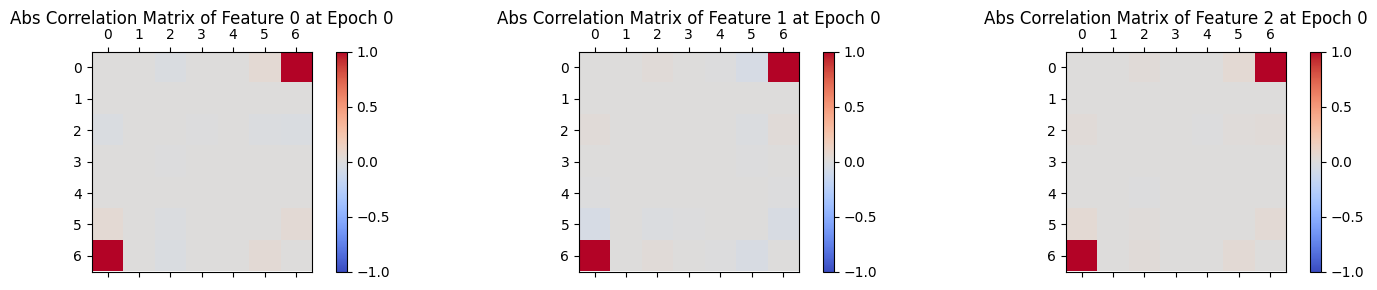

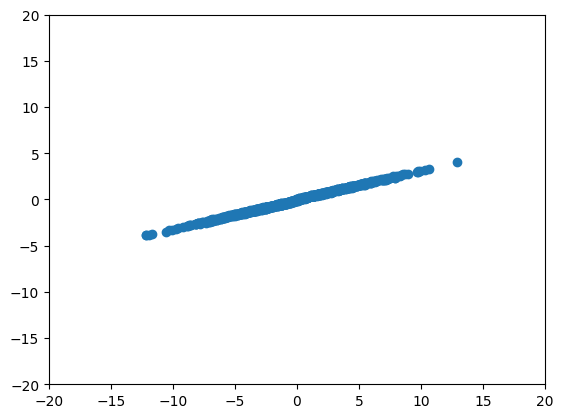

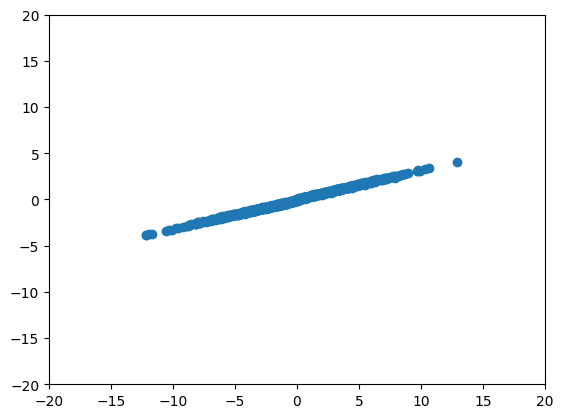

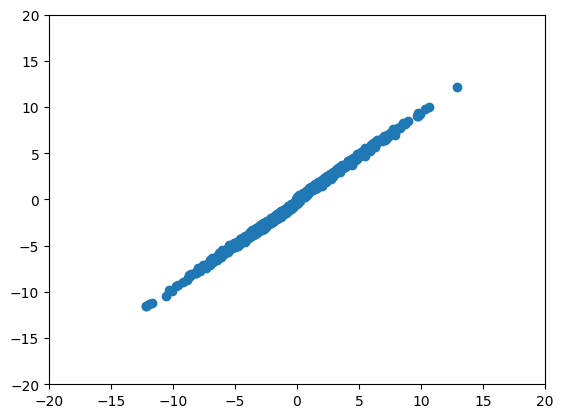

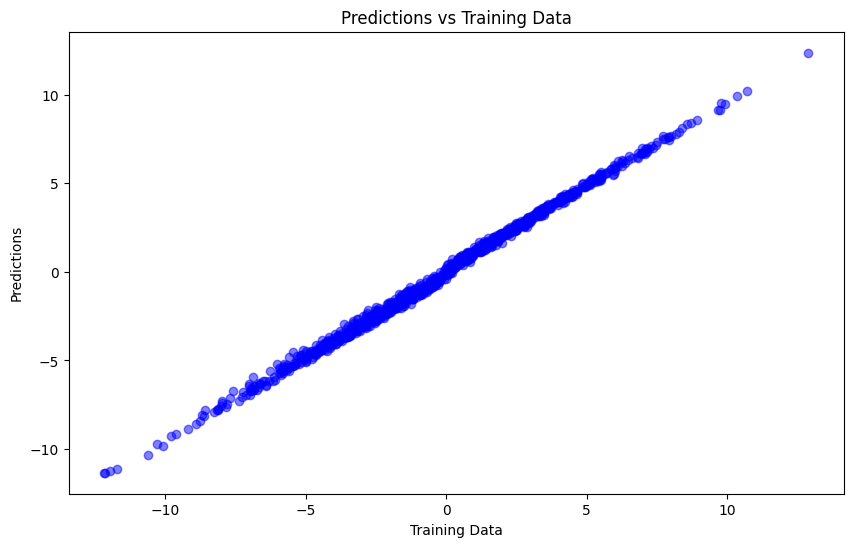

In [27]:
# x = t.tensor( [[(i-50)/100.0,(i-50)/100.0] for i in range(100) ] ).squeeze(0)
activations = [ mlp(X) for mlp in mlps]

t.set_printoptions(precision=2, sci_mode=False)

all_activations = t.stack(activations, dim=1) 

yc = t.stack([ Y for i in range(all_activations.shape[2])], dim=1).squeeze()

act_y = activations.copy()
act_y.append(yc)

plot_matrices(act_y, epoch=0)

bounds = 20

# batch, heads, features 
plt.scatter(Y, all_activations[:,0,0].detach().cpu().numpy() )
# plt.scatter(Y, all_activations[:,0,1].detach().cpu().numpy() )
# plt.scatter(Y, all_activations[:,0,2].detach().cpu().numpy() )
plt.xlim(-bounds, bounds)  # Set bounds for x-axis
plt.ylim(-bounds, bounds)  # Set bounds for y-axis
plt.show()
plt.scatter(Y, all_activations[:,0,1].detach().cpu().numpy() )
plt.xlim(-bounds, bounds)  # Set bounds for x-axis
plt.ylim(-bounds, bounds)  # Set bounds for y-axis
plt.show()
plt.scatter(Y, t.sum(all_activations[:,0,:],dim=1).detach().cpu().numpy() )
plt.xlim(-bounds, bounds)  # Set bounds for x-axis
plt.ylim(-bounds, bounds)  # Set bounds for y-axis
plt.show()
# plt.scatter(Y, X[:,0] )
# plt.scatter(Y, X[:,1] )
# plt.scatter(Y, X[:,2] )
# plt.xlim(-bounds, bounds)  # Set bounds for x-axis
# plt.ylim(-bounds, bounds)  # Set bounds for y-axis
# plt.show()

plot_predictions_vs_train( t.sum(t.stack(activations,dim=1), dim=(1,2)).unsqueeze(1), Y)

PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


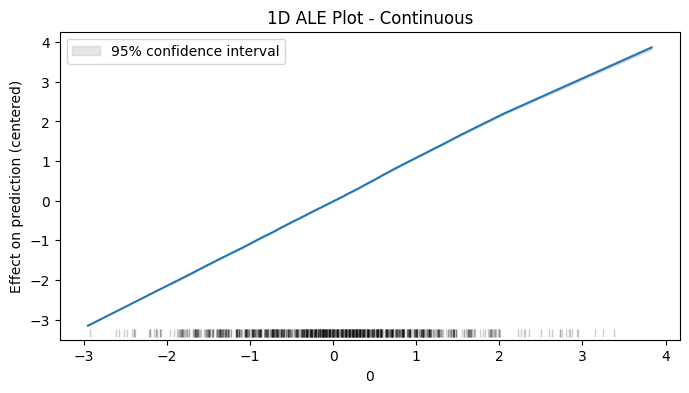

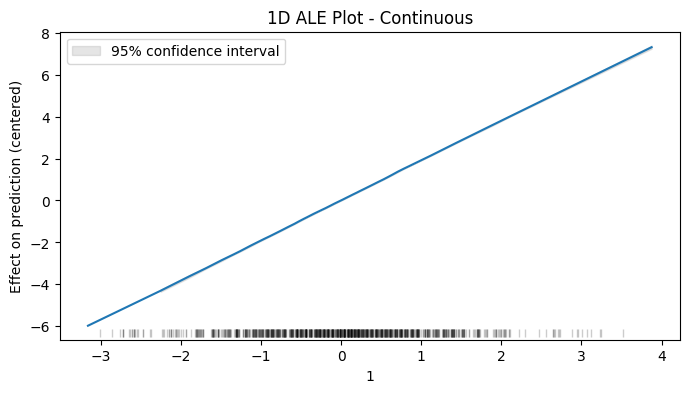

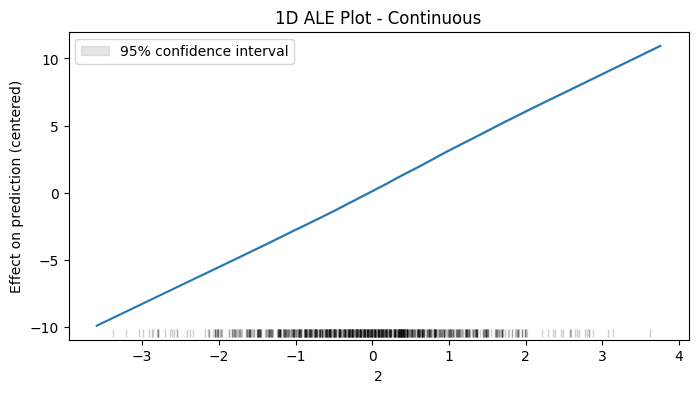

In [23]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import r2_score
from PyALE import ale
import pandas as pd

# Create a DataFrame
features=['0', '1', '2']
df = pd.DataFrame(X.detach().cpu().numpy(), columns=features)

# # Now df is a Pandas DataFrame with the data from tensor
# print(df[features])

class SKlearnModel(BaseEstimator):
    def __init__(self) :
        return

    def fit(self, X, y):
        # do nothing
        return

    def predict(self, X):
        X = t.tensor(X.to_numpy(), dtype=t.float32)
        activations = [ mlp(X) for mlp in mlps]     
        all_activations = t.stack(activations, dim=1) 
        outputs = t.sum(all_activations, dim=(1,2)).unsqueeze(1) 
        return outputs.detach().cpu().numpy()

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

# Usage:
model = SKlearnModel()

ale_eff = ale(
    X=df[features], model=model, feature=['0'], grid_size=50, include_CI=True, C=0.95
)
ale_eff = ale(
    X=df[features], model=model, feature=['1'], grid_size=50, include_CI=True, C=0.95
)
ale_eff = ale(
    X=df[features], model=model, feature=['2'], grid_size=50, include_CI=True, C=0.95
)




PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


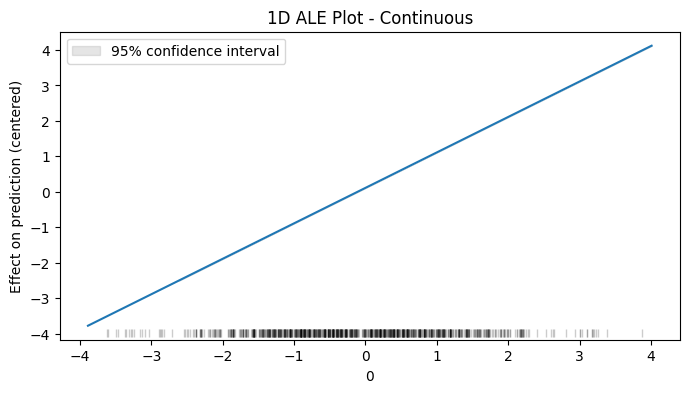

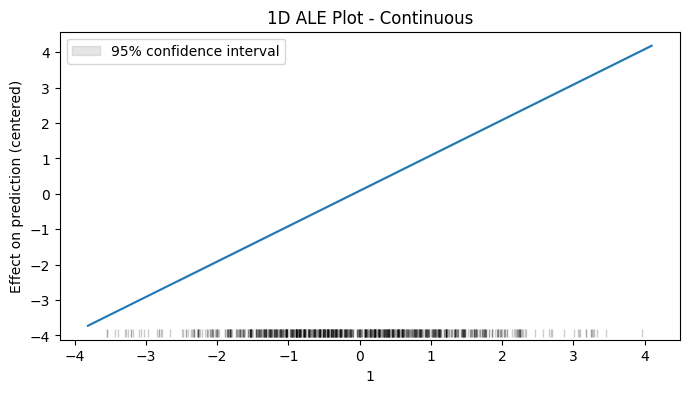

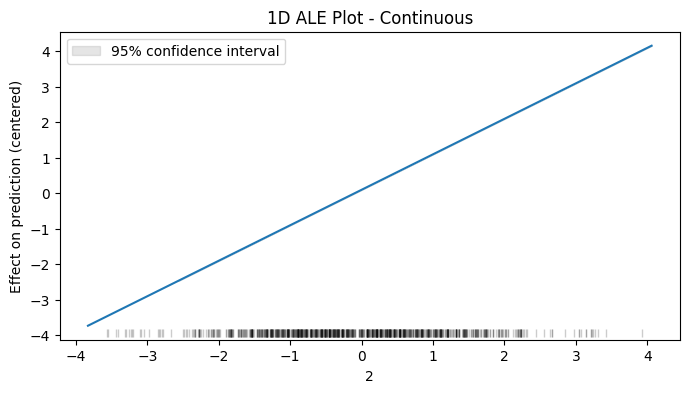

In [24]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import r2_score
from PyALE import ale
import pandas as pd


df = pd.DataFrame(all_activations[:,0,:].detach().cpu().numpy(), columns=features)

class SKlearnModel(BaseEstimator):
    def __init__(self) :
        return

    def fit(self, X, y):
        # do nothing
        return

    def predict(self, X):
        all_activations = t.tensor(X.to_numpy(), dtype=t.float32)
        outputs = t.sum(all_activations, dim=1).unsqueeze(1) 
        return outputs.detach().cpu().numpy()

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

# Usage:
model = SKlearnModel()

ale_eff0 = ale(
    X=df[features], model=model, feature=['0'], grid_size=50, include_CI=True, C=0.95
)
ale_eff1 = ale(
    X=df[features], model=model, feature=['1'], grid_size=50, include_CI=True, C=0.95
)
ale_eff2 = ale(
    X=df[features], model=model, feature=['2'], grid_size=50, include_CI=True, C=0.95
)


